In [1]:
# landcover_osm.py
from __future__ import annotations
from typing import Union, Dict, Any

from shapely.geometry import shape, Polygon, MultiPolygon
import geopandas as gpd
from OSMPythonTools.overpass import Overpass

def _geojson_to_polygon(aoi: Union[Dict[str, Any], Polygon, MultiPolygon]) -> Polygon | MultiPolygon:
    """Accept a GeoJSON dict *or* Shapely geometry and return a Shapely polygon/multipolygon."""
    if isinstance(aoi, (Polygon, MultiPolygon)):
        return aoi
    if isinstance(aoi, dict):
        return shape(aoi)
    raise TypeError("AOI must be a GeoJSON-like dict or a shapely Polygon/MultiPolygon")

def _poly_to_overpass_string(poly: Polygon | MultiPolygon) -> str:
    """Convert exterior ring(s) to the 'lat lon lat lon …' format Overpass expects."""
    if isinstance(poly, Polygon):
        rings = [poly.exterior.coords]
    else:  # MultiPolygon
        rings = [p.exterior.coords for p in poly.geoms]

    parts = []
    for ring in rings:
        parts.extend(f"{lat} {lon}" for lon, lat in ring)
    return " ".join(parts)

def _build_query(coords_str: str) -> str:
    """Raw Overpass QL requesting full geometry for land-use / natural / land-cover."""
    return f"""
    (
      way["landuse"](poly:"{coords_str}");
      way["natural"](poly:"{coords_str}");
      way["landcover"](poly:"{coords_str}");
      relation["landuse"](poly:"{coords_str}");
      relation["natural"](poly:"{coords_str}");
      relation["landcover"](poly:"{coords_str}");
    );
    out geom;
    """

def _elements_to_gdf(result) -> gpd.GeoDataFrame:
    """Convert OSMPythonTools elements → GeoPandas GeoDataFrame (EPSG:4326)."""
    geometries, attrs = [], []
    for el in result.elements():
        tags = el.tags()
        if not tags:
            continue
        geom = shape(el.geometry())
        if not geom.geom_type.startswith("Polygon"):
            continue
        geometries.append(geom)
        attrs.append(tags)

    gdf = gpd.GeoDataFrame(attrs, geometry=geometries, crs="EPSG:4326")
    gdf["cover"] = (
        gdf.get("landuse")
           .fillna(gdf.get("natural"))
           # .fillna(gdf.get("landcover"))
    )
    return gdf

# ---------------------------------------------------------------------------

def get_osm_landcover(
    aoi_geojson: Union[Dict[str, Any], Polygon, MultiPolygon],
    out_crs: str | int = "EPSG:3857",
) -> gpd.GeoDataFrame:
    """
    Retrieve OSM land-use / natural / land-cover polygons intersecting *aoi_geojson*.

    Parameters
    ----------
    aoi_geojson : dict | shapely Polygon/MultiPolygon
        The area of interest.  If dict, must be GeoJSON-like.
    out_crs : str | int, default "EPSG:3857"
        The CRS you want the result in (e.g. 4326, 3857, or any proj string).

    Returns
    -------
    GeoDataFrame
        Columns: all original OSM tag columns + 'cover' (categorical label).
        CRS: *out_crs*.
    """
    # 1. normalise AOI input
    poly = _geojson_to_polygon(aoi_geojson)

    # 2. build & run Overpass query
    overpass = Overpass()
    query = _build_query(_poly_to_overpass_string(poly))
    result = overpass.query(query)

    # 3. convert to GeoDataFrame
    gdf = _elements_to_gdf(result)

    # 4. clip to AOI
    aoi_gs = gpd.GeoSeries([poly], crs="EPSG:4326")
    gdf = gpd.clip(gdf, aoi_gs)

    # 5. project to requested CRS
    if out_crs:
        gdf = gdf.to_crs(out_crs)

    return gdf


In [2]:
# ── Cell 1 ──  Define a sample AOI (≈ 8 km-wide hexagon in the Santa Monica Mtns)
sample_geojson = {
    "type": "Polygon",
    "coordinates": [[
        [-118.526522, 34.050000],      # E
        [-118.548261, 34.081195],      # NE
        [-118.591739, 34.081195],      # NW
        [-118.613478, 34.050000],      # W
        [-118.591739, 34.018805],      # SW
        [-118.548261, 34.018805],      # SE
        [-118.526522, 34.050000]       # close ring
    ]]
}


In [3]:
# ── Cell 2 ──  Fetch OSM land-cover / land-use polygons clipped to the AOI
# from landcover_osm import get_osm_landcover
import geopandas as gpd

gdf = get_osm_landcover(sample_geojson, out_crs=3857)  # Web-Mercator for plotting
print(f"{len(gdf):,} polygons returned")
display(gdf.head())


[overpass] downloading data: [timeout:25][out:json];
    (
      way["landuse"](poly:"34.05 -118.526522 34.081195 -118.548261 34.081195 -118.591739 34.05 -118.613478 34.018805 -118.591739 34.018805 -118.548261 34.05 -118.526522");
      way["natural"](poly:"34.05 -118.526522 34.081195 -118.548261 34.081195 -118.591739 34.05 -118.613478 34.018805 -118.591739 34.018805 -118.548261 34.05 -118.526522");
      way["landcover"](poly:"34.05 -118.526522 34.081195 -118.548261 34.081195 -118.591739 34.05 -118.613478 34.018805 -118.591739 34.018805 -118.548261 34.05 -118.526522");
      relation["landuse"](poly:"34.05 -118.526522 34.081195 -118.548261 34.081195 -118.591739 34.05 -118.613478 34.018805 -118.591739 34.018805 -118.548261 34.05 -118.526522");
      relation["natural"](poly:"34.05 -118.526522 34.081195 -118.548261 34.081195 -118.591739 34.05 -118.613478 34.018805 -118.591739 34.018805 -118.548261 34.05 -118.526522");
      relation["landcover"](poly:"34.05 -118.526522 34.081195 -118.54

197 polygons returned


,name,natural,water,wikidata,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,landuse,...,religion,old_name,was:tourism,intermittent,type,ele,gnis:feature_id,leaf_type,geometry,cover
189,NaN,scrub,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,multipolygon,NaN,NaN,NaN,"POLYGON ((-13195191.832 4034016.467, -13195235...",scrub
4,Tahitian Terrace Mobile Home Park,NaN,NaN,NaN,Los Angeles,16001,90272,CA,Pacific Coast Highway,residential,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-13195536.589 4033879.982, -13195517...",residential
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-13195533.583 4034367.495, -13195533...",residential
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-13195516.663 4034390.736, -13195497...",residential
94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-13195248.939 4034138.446, -13195261...",residential


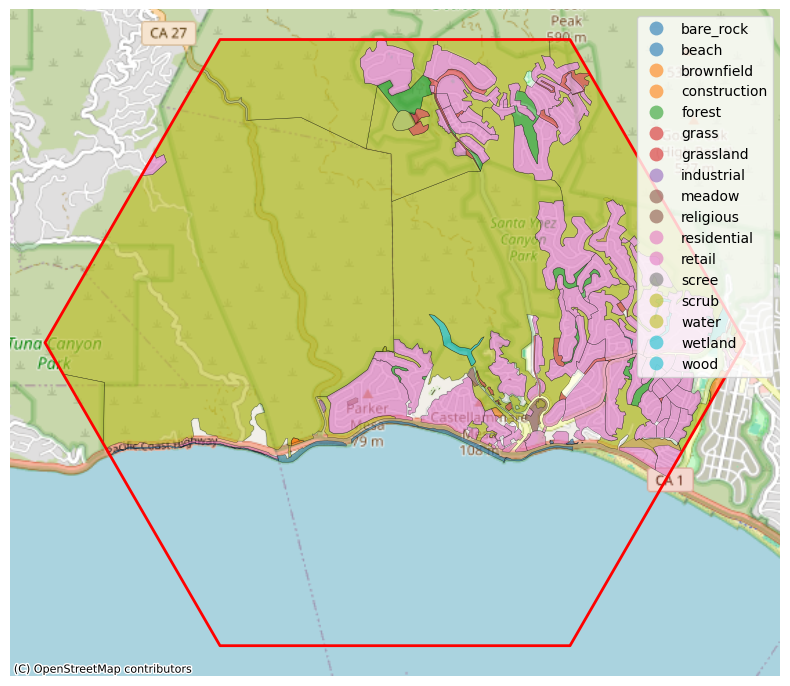

In [4]:
# ── Cell 3 ──  Plot polygons colour-coded by “cover” + AOI outline
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import shape

fig, ax = plt.subplots(figsize=(8, 8))

# land-cover
gdf.plot(
    ax=ax,
    column="cover",
    categorical=True,
    legend=True,
    alpha=0.6,
    edgecolor="k",
    linewidth=0.3,
)

# AOI boundary in red
aoi_web = (
    gpd.GeoSeries([shape(sample_geojson)], crs="EPSG:4326")
    .to_crs(3857)
)
aoi_web.boundary.plot(ax=ax, linewidth=2, color="red")

# Basemap & cosmetics
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.tight_layout()
plt.show()
